In [1]:
import synthetic_data
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
import random
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [2]:
np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

##### train and test data:

context_generator = synthetic_data.QuinticContexts(  )
context_generator.set_b(0)
context_generator.normalization()

X_train, y_train, dist_train = None, None, []
X_test, y_test, dist_test = None, None, []

for _ in range(10000):
    norm_context, distribution = context_generator.get_context(True)
    dist_train.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 
    X_train = norm_context if X_train is None else np.concatenate((X_train, norm_context), axis=0)
    y_train = [[outcome]] if y_train is None else np.concatenate( (y_train, [[outcome]]), axis=0)

for _ in range(10000):
    norm_context, distribution = context_generator.get_context(True)
    dist_test.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 
    X_test = norm_context if X_test is None else np.concatenate((X_test, norm_context), axis=0)
    y_test = [[outcome]] if y_test is None else np.concatenate( (y_test, [[outcome]]), axis=0)

In [6]:
class OriginalNetwork(nn.Module):
    def __init__(self,  d, m):
        super(OriginalNetwork, self).__init__()
        self.fc1 = nn.Linear(d, m)
        self.activate1 = nn.ReLU()
        self.fc2 = nn.Linear(m, m)
        self.activate2 = nn.ReLU()
        self.fc3 = nn.Linear(m, m)
        self.activate3 = nn.ReLU()
        self.fc4 = nn.Linear(m, 2)
        nn.init.normal_(self.fc1.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc3.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc4.weight, mean=0, std=0.1)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        nn.init.zeros_(self.fc4.bias)
    def forward(self, x):
        x = self.fc4( self.activate3( self.fc3( self.activate2( self.fc2( self.activate1( self.fc1( x ) ) ) ) ) ) )
        # x = self.fc2( self.activate1( self.fc1(x) ) ) 
        return x

# Set the random seed for reproducibility
torch.manual_seed(41)

# Create the model instance
model = OriginalNetwork(2, 20).to('cuda:0')

# Define the loss function (mean squared error) and optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay = 0 )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)

for _ in range(1000):

    model.train()

    outputs = model( torch.tensor(X_train).to('cuda').float() ) 
    y_train_mod = nn.functional.one_hot( torch.tensor(y_train).to('cuda'), num_classes=2).squeeze(1).float()
    loss = nn.BCEWithLogitsLoss()(outputs, y_train_mod )
    #Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### test and deployment loss:
    model.eval()
    with torch.no_grad():
        outputs_test = model( torch.tensor(X_test).to('cuda').float()  )
        y_test_mod = nn.functional.one_hot( torch.tensor(y_test).to('cuda'), num_classes=2).squeeze(1).float()
        loss_test = nn.BCEWithLogitsLoss()(outputs_test, y_test_mod )

    if _ % 10 == 0 :
        scheduler.step()
        print(f'Epoch {_}, Train loss: {loss.item():.4f}, Test loss: {loss_test.item():.4f}')

torch.save(model.state_dict(), './models/quintic_bce.pth')

Epoch 0, Train loss: 0.6924, Test loss: 0.6587
Epoch 10, Train loss: 0.1917, Test loss: 0.2180
Epoch 20, Train loss: 0.1544, Test loss: 0.1564
Epoch 30, Train loss: 0.1361, Test loss: 0.1403
Epoch 40, Train loss: 0.1073, Test loss: 0.1102
Epoch 50, Train loss: 0.0609, Test loss: 0.0604
Epoch 60, Train loss: 0.1015, Test loss: 0.0823
Epoch 70, Train loss: 0.0495, Test loss: 0.0537
Epoch 80, Train loss: 0.0393, Test loss: 0.0475
Epoch 90, Train loss: 0.0333, Test loss: 0.0332
Epoch 100, Train loss: 0.0248, Test loss: 0.0268
Epoch 110, Train loss: 0.0191, Test loss: 0.0225
Epoch 120, Train loss: 0.0156, Test loss: 0.0197
Epoch 130, Train loss: 0.0208, Test loss: 0.0452
Epoch 140, Train loss: 0.0589, Test loss: 0.0525
Epoch 150, Train loss: 0.0174, Test loss: 0.0418
Epoch 160, Train loss: 0.0179, Test loss: 0.0274
Epoch 170, Train loss: 0.0165, Test loss: 0.0215
Epoch 180, Train loss: 0.0140, Test loss: 0.0190
Epoch 190, Train loss: 0.0127, Test loss: 0.0164
Epoch 200, Train loss: 0.0111, 

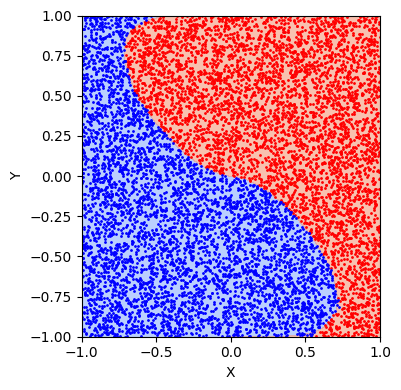

In [17]:
probabilities = torch.softmax(outputs_test, dim=1)
predictions_test = (probabilities[:, 1] >= 0.5).long().cpu()
predictions_test = np.array(predictions_test).reshape((-1,1))

# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
for idx, data in enumerate( [ (X_test,predictions_test) ] ):

    plt.figure(figsize=(4, 4))

    b = 0 if idx == 0 else 0.15
    decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)

    plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

    contexts = np.array( [ context_generator.denormalize(i) for i in data[0] ] ).squeeze(1)

    pred_action0 = [ i[0] if i[0]==0 else np.nan for i in data[1]  ]
    indices_predaction0 = np.where(~np.isnan(pred_action0))[0]
    pred_action1 = [ i[0] if i[0]==1 else np.nan for i in data[1]  ]
    indices_predaction1 = np.where(~np.isnan(pred_action1))[0]

    plt.scatter(contexts[indices_predaction0][:,0], contexts[indices_predaction0][:,1], s = 1, color='red', label='Predicted Points')
    plt.scatter(contexts[indices_predaction1][:,0], contexts[indices_predaction1][:,1], s = 1, color='blue', label='Predicted Points')

    # Add labels and title to the plot
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.title(' Decision Boundary')
    # Adjust the layout for better spacing
    plt.tight_layout()
    plt.ylim((-1,1))
    plt.xlim((-1,1))

    # Save the figure to a file with tight layout and 380 DPI
    # plt.savefig('./figures/decision_boundary_{}.png'.format(idx), dpi=380, bbox_inches='tight')